# Module 1.11: Reading the Patterns

> **Goal:** Turn visuals into insights. Translate visual patterns into modeling hypotheses and data choices.

**Duration:** ~12 minutes  
**Type:** Code / Demo

**Key Quotes:**
- "Let the patterns choose the methods."
- "Don't force a method to fit a series it doesn't understand."

---

## Prerequisites

**Inputs:**
- `./output/m5_weekly_clean.parquet` — From Module 1.9
- `./output/series_zero_stats.parquet` — From Module 1.10 (optional)

**What this module produces:**
- Pattern assessment functions
- Series segmentation by behavior
- `./output/series_playbook.parquet` — Method recommendations per series

**Data Flow:**
```
Module 1.10 (plotting, visual EDA)
    → Module 1.11 (reading patterns) ← YOU ARE HERE
        → Module 1.12 (leakage guardrails)
```

---

## 1. From Seeing to Deciding

In Module 1.10, we learned to **see** patterns. Now we learn to **act** on them.

### The 5 Key Patterns

| Pattern | What to Look For | Why It Matters |
|---------|------------------|----------------|
| **Trend** | Upward/downward slope | Determines if differencing or trend terms needed |
| **Seasonality** | Repeating cycles | Guides Fourier terms, seasonal decomposition |
| **Volatility** | Changing variance | Suggests log transform or robust methods |
| **Intermittency** | Many zeros | Requires specialized methods (Croston, etc.) |
| **Events/Anomalies** | Irregular spikes | Need event features or outlier handling |

### The Pattern-to-Method Framework

```
See Pattern → Assess Strength → Choose Method → Document Decision
```

## 2. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Optional: TSForge plotting
try:
    from tsforge.plots import plot_timeseries
    HAS_TSFORGE = True
except ImportError:
    HAS_TSFORGE = False
    print("Note: tsforge not available, using matplotlib")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Create output directory
Path('./output').mkdir(exist_ok=True)

print('✓ Setup complete')

✓ Setup complete


In [2]:
# Load data from Module 1.9
df = pd.read_parquet('./output/m5_weekly_clean.parquet')

# Extract metadata from unique_id
# M5 format: {CAT}_{DEPT_NUM}_{ITEM_NUM}_{STATE}_{STORE_NUM}
df['store_id'] = df['unique_id'].str.extract(r'_([A-Z]{2}_\d+)$')[0]
df['state_id'] = df['store_id'].str[:2]
df['dept_id'] = df['unique_id'].str.extract(r'^([A-Z]+_\d+)')[0]
df['cat_id'] = df['unique_id'].str.extract(r'^([A-Z]+)')[0]

# Load zero stats from Module 1.10 if available
try:
    zero_stats = pd.read_parquet('./output/series_zero_stats.parquet')
    print(f"✓ Loaded zero stats for {len(zero_stats):,} series")
except FileNotFoundError:
    print("Computing zero stats...")
    zero_stats = df.groupby('unique_id')['y'].apply(lambda x: (x == 0).mean() * 100).reset_index()
    zero_stats.columns = ['unique_id', 'zero_pct']

print(f"\nData: {len(df):,} rows, {df['unique_id'].nunique():,} series")
print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")
print(f"Categories: {df['cat_id'].unique().tolist()}")

✓ Loaded zero stats for 30,490 series

Data: 6,848,887 rows, 30,490 series
Date range: 2011-01-29 to 2016-06-25
Categories: ['FOODS', 'HOBBIES', 'HOUSEHOLD']


## 3. Pattern 1: Trend Assessment

### Decision Tree for Trend

```
Is there a trend?
├── NO (R² < 0.1) → Skip trend component
└── YES → Is it linear?
    ├── YES (R² > 0.3) → Linear trend or differencing
    └── NO → Check for level shifts or exponential growth
```

In [ ]:
# Test on a sample series
sample_id = df['unique_id'].iloc[0]
sample_y = df[df['unique_id'] == sample_id]['y'].values
trend_result = tsf.assess_trend(sample_y)

print(f"Trend Assessment for {sample_id}:")
for k, v in trend_result.items():
    print(f"  {k}: {v}")

Trend Assessment for FOODS_1_001_CA_1:
  trend_slope: -0.0064
  trend_slope_pct: -0.12
  trend_strength: 0.02
  p_value: 0.0161
  recommendation: no_trend


## 4. Pattern 2: Seasonality Assessment

### Seasonality with Weekly Data

Since we have weekly data, we look for:

| Seasonality | Period | Method |
|-------------|--------|--------|
| Monthly | ~4 weeks | Month features |
| Quarterly | ~13 weeks | Quarter indicators |
| Annual | 52 weeks | Fourier(52), yearly seasonality |

### Measuring Seasonal Strength

Using STL decomposition: `strength = 1 - Var(residual) / Var(seasonal + residual)`

In [ ]:
# Test
seasonal_result = tsf.assess_seasonality(sample_y)
print(f"Seasonality Assessment for {sample_id}:")
for k, v in seasonal_result.items():
    print(f"  {k}: {v}")

Seasonality Assessment for FOODS_1_001_CA_1:
  seasonal_strength: 0.098
  recommendation: weak_seasonality


## 5. Pattern 3: Volatility Assessment

### Why Volatility Matters

| Volatility Pattern | Implication |
|--------------------|-------------|
| Constant variance | Standard methods OK |
| Variance ∝ Level | Log transform recommended |
| High overall CV | Wide prediction intervals needed |

In [ ]:
# Test
vol_result = tsf.assess_volatility(sample_y)
print(f"Volatility Assessment for {sample_id}:")
for k, v in vol_result.items():
    print(f"  {k}: {v}")

Volatility Assessment for FOODS_1_001_CA_1:
  cv: 0.6700000166893005
  level_variance_corr: 0.699
  p_value: 0.0
  recommendation: standard_methods_ok


## 6. Pattern 4: Intermittency Classification

### Intermittency Thresholds

| Zero % | Category | Recommended Methods |
|--------|----------|---------------------|
| 0-10% | Continuous | Standard methods |
| 10-30% | Mildly intermittent | Standard + monitoring |
| 30-50% | Intermittent | Croston, SBA, TSB |
| 50-70% | Highly intermittent | Specialized methods |
| 70%+ | Sporadic | Aggregate or simple |

In [ ]:
int_result = tsf.classify_intermittency(sample_y)
print(f"Intermittency Classification for {sample_id}:")
for k, v in int_result.items():
    print(f"  {k}: {v}")

Intermittency Classification for FOODS_1_001_CA_1:
  zero_pct: 9.5
  category: continuous
  recommendation: standard_methods


## 7. Pattern 5: Anomaly Detection

Using MAD (Median Absolute Deviation) for robust outlier detection.

In [ ]:
anom_result = tsf.detect_anomalies(sample_y)
print(f"Anomaly Detection for {sample_id}:")
for k, v in anom_result.items():
    if k != 'anomaly_indices':
        print(f"  {k}: {v}")
print(f"  anomaly_indices: {anom_result['anomaly_indices'][:5]}..." if anom_result['anomaly_indices'] else "  anomaly_indices: []")

Anomaly Detection for FOODS_1_001_CA_1:
  n_anomalies: 12
  anomaly_pct: 4.24
  recommendation: minor_anomalies
  anomaly_indices: [4, 5, 14, 17, 44]...


## 8. Combined Pattern Assessment

In [ ]:
# Full assessment on sample
assessment = tsf.full_pattern_assessment(sample_y, sample_id)

print(f"Full Pattern Assessment: {sample_id}")
print("=" * 50)
print(f"Observations: {assessment['n_obs']}")
print(f"\nTrend: {assessment['trend']['recommendation']} (R²={assessment['trend']['trend_strength']})")
print(f"Seasonality: {assessment['seasonality']['recommendation']} (strength={assessment['seasonality']['seasonal_strength']})")
print(f"Volatility: {assessment['volatility']['recommendation']} (CV={assessment['volatility']['cv']})")
print(f"Intermittency: {assessment['intermittency']['category']} ({assessment['intermittency']['zero_pct']}% zeros)")
print(f"Anomalies: {assessment['anomalies']['recommendation']} ({assessment['anomalies']['n_anomalies']} found)")

Full Pattern Assessment: FOODS_1_001_CA_1
Observations: 283

Trend: no_trend (R²=0.02)
Seasonality: weak_seasonality (strength=0.098)
Volatility: standard_methods_ok (CV=0.6700000166893005)
Intermittency: continuous (9.5% zeros)
Anomalies: minor_anomalies (12 found)


## 9. Series Segmentation Strategy

Group series by behavior to apply appropriate methods to each segment.

Series Segmentation Results
segment
intermittent    11223
standard        10492
high_volume      5069
sporadic         3706
Name: count, dtype: int64


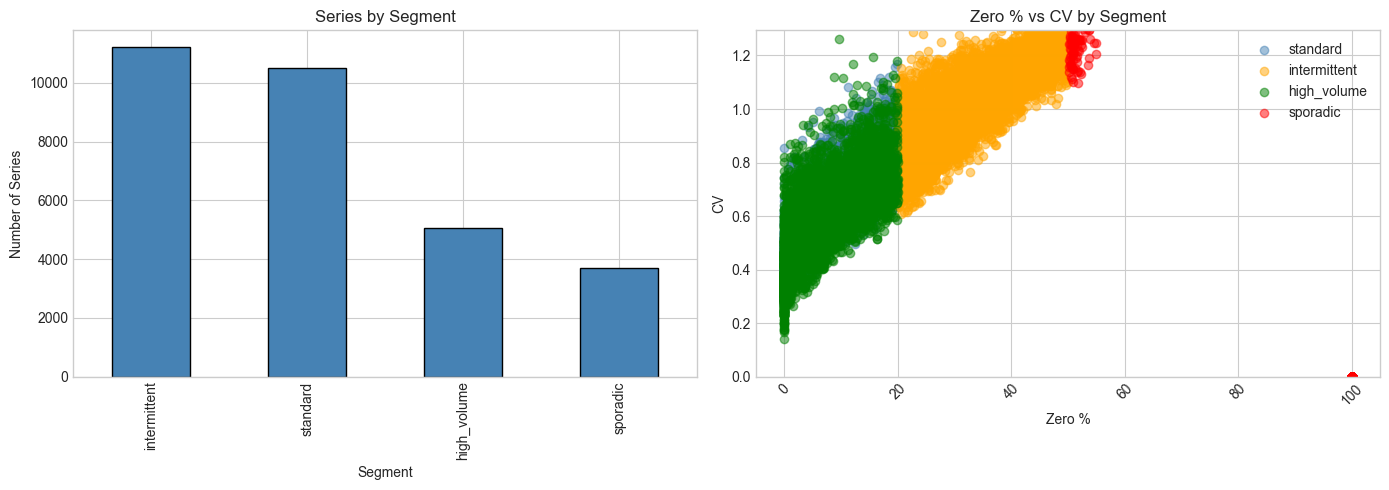

In [ ]:
# Segment all series
segments = tsf.segment_series(df)

tsf.plot_segment_stats(segments)

## 10. Method Recommendations by Segment

### Mapping Segments to Methods

| Segment | Characteristics | Recommended Methods |
|---------|-----------------|---------------------|
| **sporadic** | >50% zeros | Aggregate up, simple methods, or accept high error |
| **intermittent** | 20-50% zeros | Croston, SBA, TSB, IMAPA |
| **volatile** | High CV, variable demand | Robust methods, wide intervals |
| **high_volume** | Top 20% by volume | ML models, global models, more features |
| **standard** | Everything else | ETS, ARIMA, Theta, statistical methods |

In [ ]:
# Show recommendations for each segment
print("Method Recommendations by Segment")
print("=" * 60)
for seg in ['sporadic', 'intermittent', 'volatile', 'high_volume', 'standard']:
    rec = tsf.recommend_method(seg)
    print(f"\n{seg.upper()}:")
    print(f"  Primary approach: {rec['primary']}")
    print(f"  Models: {', '.join(rec['models'])}")
    print(f"  Notes: {rec['notes']}")

Method Recommendations by Segment

SPORADIC:
  Primary approach: simple_methods
  Models: Naive, SeasonalNaive, SES
  Notes: Consider aggregating to higher level

INTERMITTENT:
  Primary approach: intermittent_demand
  Models: Croston, SBA, TSB, IMAPA
  Notes: Specialized for sparse demand

VOLATILE:
  Primary approach: robust_methods
  Models: Theta, RobustETS, MedianEnsemble
  Notes: Use wide prediction intervals

HIGH_VOLUME:
  Primary approach: ml_models
  Models: LightGBM, XGBoost, GlobalModels, DeepAR
  Notes: Rich feature engineering recommended

STANDARD:
  Primary approach: statistical
  Models: ETS, ARIMA, Theta
  Notes: Standard time series methods


## 11. Generate the Series Playbook

Create a comprehensive playbook with segment and method for every series.

In [ ]:
# Generate playbook
print("Generating series playbook...")
playbook = tsf.generate_playbook(df)

print(f"\nPlaybook generated for {len(playbook):,} series")
print("\nPlaybook preview:")
display(playbook.head(10))

print("\nSegment distribution:")
print(playbook['segment'].value_counts())

print("\nMethod distribution:")
print(playbook['recommended_method'].value_counts())

Generating series playbook...

Playbook generated for 30,490 series

Playbook preview:


,unique_id,segment,total,mean,zero_pct,cv,recommended_method,recommended_models,transform
0,FOODS_1_001_CA_1,standard,1544.0,5.455831,9.540636,0.671076,statistical,"ETS, ARIMA, Theta",none
1,FOODS_1_001_CA_2,standard,2287.0,8.081272,9.540636,0.709898,statistical,"ETS, ARIMA, Theta",none
2,FOODS_1_001_CA_3,standard,2367.0,8.363957,10.600707,0.797903,statistical,"ETS, ARIMA, Theta",none
3,FOODS_1_001_CA_4,intermittent,712.0,2.524823,21.631206,0.830773,intermittent_demand,"Croston, SBA, TSB",none
4,FOODS_1_001_TX_1,standard,1105.0,3.918440,17.021277,0.847800,statistical,"ETS, ARIMA, Theta",none
5,FOODS_1_001_TX_2,standard,1128.0,4.000000,13.829787,0.790851,statistical,"ETS, ARIMA, Theta",none
6,FOODS_1_001_TX_3,standard,809.0,2.879004,15.658363,0.794205,statistical,"ETS, ARIMA, Theta",none
7,FOODS_1_001_WI_1,standard,1108.0,3.929078,10.992908,0.746375,statistical,"ETS, ARIMA, Theta",none
8,FOODS_1_001_WI_2,intermittent,907.0,3.216312,22.695035,0.908987,intermittent_demand,"Croston, SBA, TSB",none
9,FOODS_1_001_WI_3,intermittent,533.0,1.890071,34.397163,1.111241,intermittent_demand,"Croston, SBA, TSB",log



Segment distribution:
segment
intermittent    11223
standard        10492
high_volume      5069
sporadic         3706
Name: count, dtype: int64

Method distribution:
recommended_method
intermittent_demand    11223
statistical            10492
ml_models               5069
simple_methods          3706
Name: count, dtype: int64


In [13]:
# Save playbook
playbook.to_parquet('./output/series_playbook.parquet', index=False)
playbook.to_csv('./output/series_playbook.csv', index=False)

print("✓ Saved:")
print("  ./output/series_playbook.parquet")
print("  ./output/series_playbook.csv")

✓ Saved:
  ./output/series_playbook.parquet
  ./output/series_playbook.csv


## 12. Key Takeaways

### The Pattern-to-Method Framework

| Pattern | Assessment | Action |
|---------|------------|--------|
| Trend | R² from linear regression | Add trend terms or difference |
| Seasonality | STL strength metric | Add Fourier/seasonal features |
| Volatility | CV, level-variance correlation | Log transform if correlated |
| Intermittency | Zero percentage | Use specialized methods |
| Anomalies | MAD-based detection | Flag for investigation |

### Segmentation Strategy

```
Series Portfolio
├── Sporadic (>50% zeros) → Simple methods, aggregate
├── Intermittent (20-50% zeros) → Croston, SBA, TSB
├── Volatile (high CV) → Robust methods
├── High Volume (top 20%) → ML, rich features
└── Standard (rest) → ETS, ARIMA, Theta
```

### Golden Rules

1. **"Let the patterns choose the methods"** — Don't force-fit
2. **Segment by behavior, not by category** — FOODS can be sporadic too
3. **Document everything** — The playbook is your audit trail
4. **Reassess periodically** — Patterns can change over time

---

## What's Next

**Module 1.12: Leakage Guardrails**
- Ensure features don't leak future information
- Build safe lag features

In [14]:
# Summary
print("=" * 60)
print("MODULE 1.11 COMPLETE")
print("=" * 60)
print("\nOutputs:")
print("  ./output/series_playbook.parquet")
print("  ./output/series_playbook.csv")
print("\nFunctions defined:")
print("  assess_trend() - Linear trend analysis")
print("  assess_seasonality() - STL-based seasonal strength")
print("  assess_volatility() - CV and level-variance analysis")
print("  classify_intermittency() - Zero-based classification")
print("  detect_anomalies() - MAD-based outlier detection")
print("  full_pattern_assessment() - All patterns combined")
print("  segment_series() - Behavior-based segmentation")
print("  recommend_method() - Segment to method mapping")
print("  generate_playbook() - Full playbook generation")

MODULE 1.11 COMPLETE

Outputs:
  ./output/series_playbook.parquet
  ./output/series_playbook.csv

Functions defined:
  assess_trend() - Linear trend analysis
  assess_seasonality() - STL-based seasonal strength
  assess_volatility() - CV and level-variance analysis
  classify_intermittency() - Zero-based classification
  detect_anomalies() - MAD-based outlier detection
  full_pattern_assessment() - All patterns combined
  segment_series() - Behavior-based segmentation
  recommend_method() - Segment to method mapping
  generate_playbook() - Full playbook generation
